## Random Forests and SHAP Value

The Random Forest algorithm leverages multiple decision trees to make predictions, drawing on varying subsets of data and features. Its inherent resilience against overfitting ensures a reliable model that generalizes effectively to unseen data. Moreover, its ability to process non-linear relationships between features helps capture complex data patterns, thereby enhancing the model's predictive accuracy. An added advantage of using Random Forests lies in its inherent ability to estimate feature importance, providing a quantifiable measure of each predictor's contribution towards the final prediction.aggregating predictions.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
import shap
# Read data
new_dataset_efmjieh1 = pd.read_csv("imputedfi.csv")
# Specify the variables to scale
numerical_variables = ["efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
"efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", "efinva", "efoasgi", "efogovtr", "efothinc", "efpen", "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", "efsapis", "efsemp", 
"efsize", "efuiben", "efwkrcp", "efagofmp", "efagyfmp", "hlev2g"]

# Specify categorical variables
categorical_variables = ["eftyp", "prov", "dwltyp", "dwtenr", "marstp", "efmjsi","sex","immst","uszgap"]
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['fschhldm'] >= 1, 'fschhldm'] = 1

In [2]:
# Create the target and features
y = new_dataset_efmjieh1['fschhldm']
X = new_dataset_efmjieh1.drop(columns=['fschhldm'])

# Numerical features to scale
cols_to_scale = numerical_variables

# Define pipeline for scaling numerical features and one-hot encoding categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_scale),
        ('cat', categorical_transformer, categorical_variables)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Create a mask for SMOTENC after one-hot encoding
# True for categorical features and False for numerical features
categorical_features_mask = np.concatenate(
    [np.full(len(cols_to_scale), False),
     np.full(preprocessor.transformers_[1][1].categories_[0].shape[0], True)]
)

# Apply SMOTENC
smote_nc = SMOTENC(categorical_features=categorical_features_mask, random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = smote_nc.fit_resample(X_preprocessed, y)

# Encode the labels
le = LabelEncoder()
y_resampled_ready = le.fit_transform(y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train_ready, y_test_ready = train_test_split(X_resampled, y_resampled_ready, random_state=42, stratify=y_resampled_ready)


In [3]:
# Define and fit the classifier
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(X_train, y_train_ready)

RandomForestClassifier(n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26545
           1       1.00      1.00      1.00     26546

    accuracy                           1.00     53091
   macro avg       1.00      1.00      1.00     53091
weighted avg       1.00      1.00      1.00     53091

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      8849
           1       0.94      0.89      0.91      8848

    accuracy                           0.92     17697
   macro avg       0.92      0.92      0.92     17697
weighted avg       0.92      0.92      0.92     17697



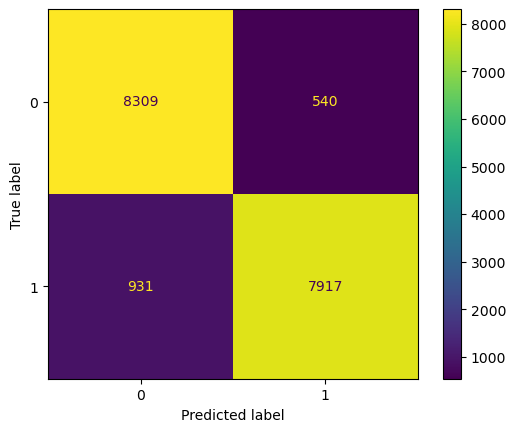

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
# Make predictions
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

# Print classification reports
print(classification_report(y_train_ready, y_hat_train))
print(classification_report(y_test_ready, y_hat_test))

# Plot confusion matrix
cm = confusion_matrix(y_test_ready, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 
plt.show()

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Compute training and test accuracy
train_acc = accuracy_score(y_train_ready, y_hat_train)
test_acc = accuracy_score(y_test_ready, y_hat_test)

print("Training Accuracy: {:.2f}%".format(train_acc * 100))
print("Test Accuracy: {:.2f}%".format(test_acc * 100))
# Compute probabilities
y_train_proba = clf.predict_proba(X_train)[:, 1]
y_test_proba = clf.predict_proba(X_test)[:, 1]

# Compute ROC AUC
roc_auc_train = roc_auc_score(y_train_ready, y_train_proba)
roc_auc_test = roc_auc_score(y_test_ready, y_test_proba)

print("Training ROC AUC: {:.2f}".format(roc_auc_train))
print("Test ROC AUC: {:.2f}".format(roc_auc_test))

Training Accuracy: 100.00%
Test Accuracy: 91.69%
Training ROC AUC: 1.00
Test ROC AUC: 0.97


### **Measures of Feature Importance:** 

#### **Gini Importance**

Gini Importance provides a global measure of feature importance by indicating a feature's overall influence within the model, without specifying the direction (positive or negative) of this influence. The importance of correlated features might be distributed among them. Notably, Gini Importance can sometimes be inconsistent, meaning that the importance of a feature may decrease if additional useful features are included in the model.

#### **SHAP Values**

The SHAP framework was implemented for the top-performing model to interpret the predictions made by complex machine learning algorithms. This game-theory-based method determines the contributions of predictor features to the final predictions, treating predictor features as players in a coalitional game. The game payoff (or the predicted probability in our case) is distributed among the features based on Shapley concepts in game theory. Compared to Gini Importance, SHAP values provide local interpretability and overall feature importance. This approach offers a more accurate representation of feature importance when features are correlated. SHAP values also ensure a fair and consistent distribution of contribution among features, thanks to their grounding in cooperative game theory. A comparison between these two measures is detailed below.

### Difference between Gini importance and SHAP-values

|                             | Gini Importance                                                     | SHAP Values                                                                |
|-----------------------------|---------------------------------------------------------------------|----------------------------------------------------------------------------|
| Global vs. Local            | Provides a global measure of feature importance across all instances | Provides local interpretability as well as a global measure of importance  |
| Correlated Features         | Can overestimate the importance of correlated features              | Accurately handles correlated features by calculating all possible combinations |
| Consistency                 | Can be inconsistent in certain situations                          | Consistent, feature importance does not decrease with additional useful features |
| Fair Contribution           | Does not offer a fair distribution of contribution among features   | Provides a fair distribution of contribution among features based on cooperative game theory |
| Direction of Importance     | Does not provide information about the direction of feature importance | Provides information about the direction of feature importance (i.e., positive or negative impact on output) |
| Computational Efficiency    | Less computationally intensive                                      | More computationally intensive                                            |



In [6]:
import shap

# Create an explainer object with the random forest model
explainer = shap.TreeExplainer(clf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

In [12]:
import pickle
# Save the explainer
with open('explainer.pkl', 'wb') as file:
    pickle.dump(explainer, file)

# Save the SHAP values
with open('shap_values.pkl', 'wb') as file:
    pickle.dump(shap_values, file)


In [13]:
import pickle

# Save the trained classifier
with open('clf.pkl', 'wb') as file:
    pickle.dump(clf, file)

# Save the LabelEncoder
with open('le.pkl', 'wb') as file:
    pickle.dump(le, file)

# Save the ColumnTransformer
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)


In [14]:
# Save X_train
with open('X_train.pkl', 'wb') as file:
    pickle.dump(X_train, file)

# Save X_test
with open('X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)

# Save y_train_ready
with open('y_train_ready.pkl', 'wb') as file:
    pickle.dump(y_train_ready, file)

# Save y_test_ready
with open('y_test_ready.pkl', 'wb') as file:
    pickle.dump(y_test_ready, file)


In [6]:
import pickle

# Load the explainer
with open('explainer.pkl', 'rb') as file:
    explainer = pickle.load(file)

# Load the SHAP values
with open('shap_values.pkl', 'rb') as file:
    shap_values = pickle.load(file)


In [7]:
import pickle

# Load the trained classifier
with open('clf.pkl', 'rb') as file:
    clf = pickle.load(file)

# Load the LabelEncoder
with open('le.pkl', 'rb') as file:
    le = pickle.load(file)

# Load the ColumnTransformer
with open('preprocessor.pkl', 'rb') as file:
    preprocessor = pickle.load(file)

# Load X_train
with open('X_train.pkl', 'rb') as file:
    X_train = pickle.load(file)

# Load X_test
with open('X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)

# Load y_train_ready
with open('y_train_ready.pkl', 'rb') as file:
    y_train_ready = pickle.load(file)

# Load y_test_ready
with open('y_test_ready.pkl', 'rb') as file:
    y_test_ready = pickle.load(file)


In [8]:
# Feature importances for RandomForest
feature_importances = clf.feature_importances_

# Retrieve the list of categories from OneHotEncoder
categories = preprocessor.transformers_[1][1].categories_

# Create a list of the names of categorical variables after one-hot encoding
onehot_feature_names = []
for col, cats in zip(categorical_variables, categories):
    for cat in cats:
        onehot_feature_names.append(f"{col}_{cat}")

# Combine the list of numerical and one-hot encoded categorical features
feature_names = cols_to_scale + onehot_feature_names

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': feature_importances
})

# Sort by importance
feature_importances_df.sort_values('Importance', ascending=False, inplace=True)

# Feature importances for RandomForest
feature_importances = clf.feature_importances_

# Retrieve the list of categories from OneHotEncoder
categories = preprocessor.transformers_[1][1].categories_

# Create a list of the names of categorical variables after one-hot encoding
onehot_feature_names = []
for col, cats in zip(categorical_variables, categories):
    for cat in cats:
        onehot_feature_names.append(f"{col}_{cat}")

# Combine the list of numerical and one-hot encoded categorical features
feature_names = cols_to_scale + onehot_feature_names

# Create a DataFrame to display feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': feature_importances
})

# Sort by importance
feature_importances_df.sort_values('Importance', ascending=False, inplace=True)

# Display the DataFrame
print(feature_importances_df)


       Feature  Importance
25    efagofmp    0.062952
17     efpvtxc    0.056598
27      hlev2g    0.053673
6      efearng    0.050301
8      efgstxc    0.048732
..         ...         ...
37  eftyp_32.0    0.001116
28  eftyp_11.0    0.001049
39  eftyp_42.0    0.000667
67    efmjsi_7    0.000599
38  eftyp_41.0    0.000577

[82 rows x 2 columns]


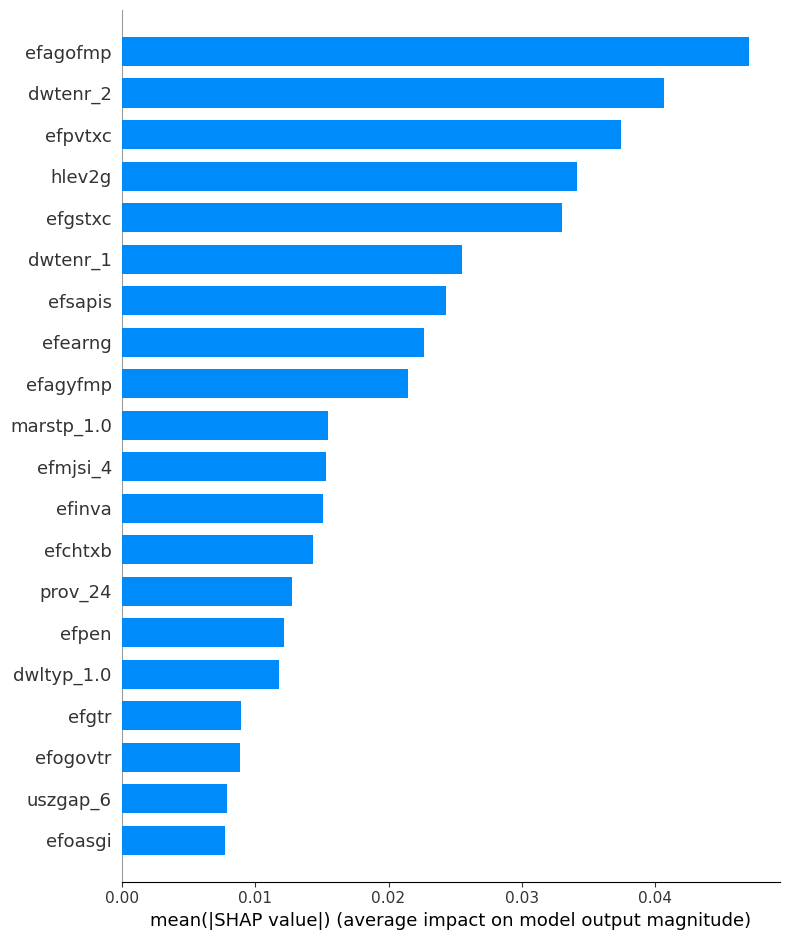

In [9]:
# Plot the SHAP values
shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


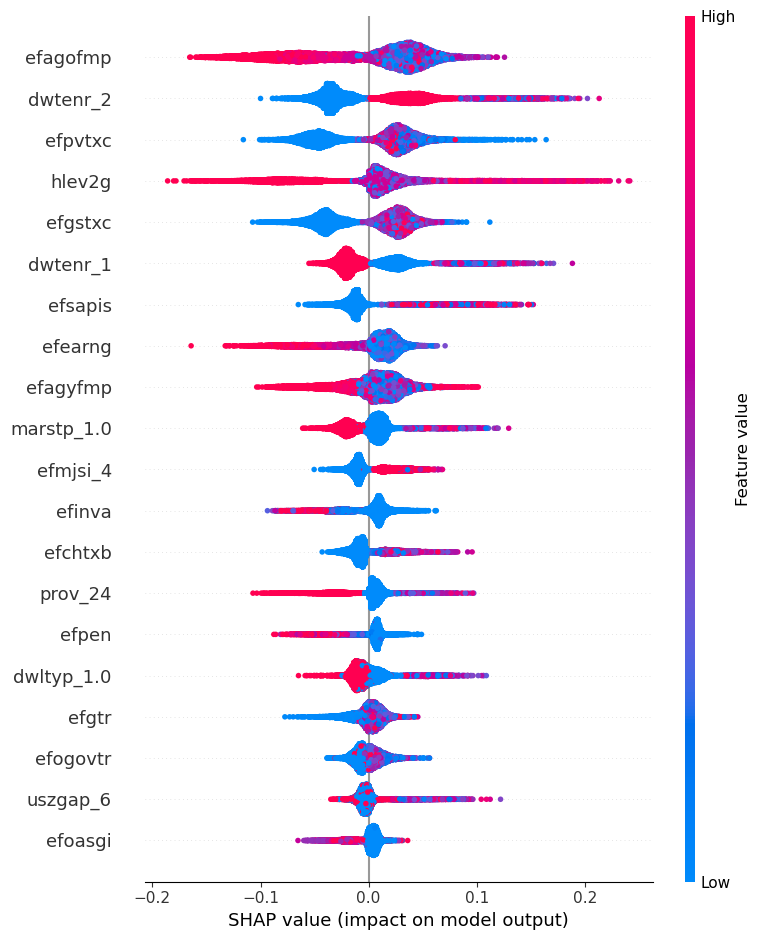

In [10]:
# Plot the SHAP values
shap.summary_plot(shap_values[1], X_test, feature_names=feature_names)

The figure above exhibits the 20 most significant features as measured by SHAP-values. The x-axis in the plot denotes the feature's impact on the model's prediction, with the color indicating the feature's value (red for high, blue for low). A positive SHAP-value implies the feature's presence enhances the model's output, thus increasing the projected likelihood of food insecurity.
It is pertinent to note that SHAP utilizes dummy variables (also known as one-hot encoding) for categorical variables.  
The "bulb" shape around the 0.05 SHAP-value implies a substantial number of observations sharing a similar SHAP-value. The blend of purple and blue points suggests that both moderate and low age groups of the oldest person in a household slightly increase the predicted likelihood of food insecurity. The substantial stretch of negative SHAP-values on the plot's left side indicates that a higher age generally lowers food insecurity likelihood. The lack of a bulb shape implies a more linear relationship.  
One key feature is the type of dwelling not owned by a household member (i.e., renter status). A blue bulb with a small negative SHAP-value indicates that homeownership slightly decreases predicted food insecurity. In contrast, the majority of red points on the right suggests that renters have a stronger inclination towards food insecurity, corroborating existing literature.  
The highest level of education of the major earner (hlev2g) displays wide ranges of both positive and negative SHAP-values, indicating its diverse impact on the prediction. Most blue and purple points with small negative SHAP-values, suggest lower education levels have a small impact on food insecurity prediction. Considering that the highest hlev2g level represents a university degree or certificate, further investigation into the association between these qualifications and food insecurity is warranted.

### SHAP Waterfall Plot

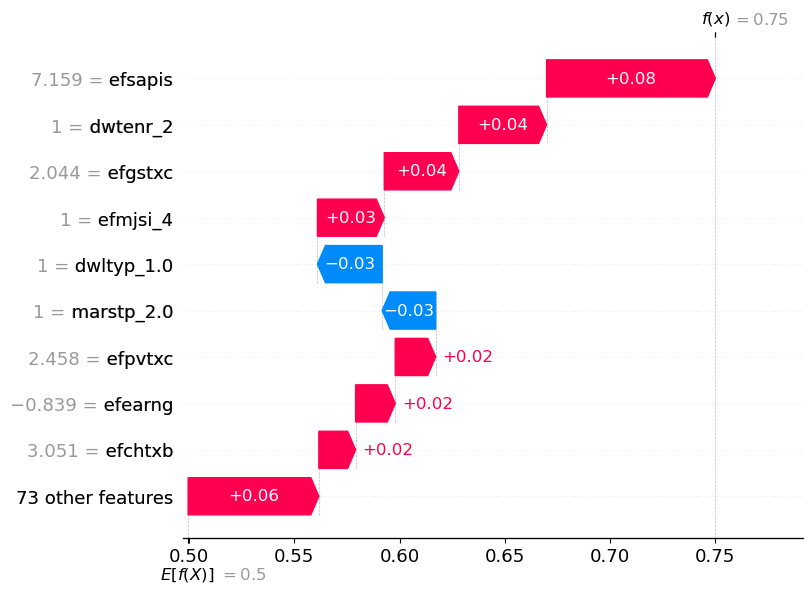

In [12]:
import shap
# Your feature names list
feature_names1 = ['efalimo', 'efalip', 'efcapgn', 'efccar', 'efchtxb', 'efcpqpp', 'efearng', 'efgi', 'efgstxc', 
                 'efgtr', 'efinva', 'efoasgi', 'efogovtr', 'efothinc', 'efpen', 'efpenrec', 'efphpr', 'efpvtxc', 
                 'efrppc', 'efrspwi', 'efsapis', 'efsemp', 'efsize', 'efuiben', 'efwkrcp', 'efagofmp', 'efagyfmp', 
                 'hlev2g', 'eftyp_11.0', 'eftyp_12.0', 'eftyp_13.0', 'eftyp_14.0', 'eftyp_21.0', 'eftyp_22.0', 
                 'eftyp_23.0', 'eftyp_24.0', 'eftyp_31.0', 'eftyp_32.0', 'eftyp_41.0', 'eftyp_42.0', 'eftyp_43.0', 
                 'eftyp_44.0', 'prov_10', 'prov_11', 'prov_12', 'prov_13', 'prov_24', 'prov_35', 'prov_46', 'prov_47', 
                 'prov_48', 'prov_59', 'dwltyp_1.0', 'dwltyp_2.0', 'dwltyp_3.0', 'dwltyp_4.0', 'dwtenr_1', 'dwtenr_2', 
                 'marstp_1.0', 'marstp_2.0', 'marstp_3.0', 'marstp_4.0', 'efmjsi_2', 'efmjsi_3', 'efmjsi_4', 'efmjsi_5', 
                 'efmjsi_6', 'efmjsi_7', 'sex_1', 'sex_2', 'immst_1', 'immst_2', 'immst_9', 'uszgap_1', 'uszgap_2', 
                 'uszgap_3', 'uszgap_4', 'uszgap_5', 'uszgap_6', 'uszgap_7', 'uszgap_8', 'uszgap_9']

# Select a specific instance index from your test set
instance_index = 9

# Create an Explanation object for the specific instance
shap_object = shap.Explanation(base_values = explainer.expected_value[1],
                               values = shap_values[1][instance_index],
                               feature_names = feature_names1,
                               data = X_test[instance_index])

# Generate the waterfall plot for the specific instance
shap.plots.waterfall(shap_object)

We can isolate one single observation and calculate the SHAP values for this specific data point.

In the waterfall plot above, the x-axis represents the values of the target (dependent) variable, which in this case, is the probability of being food insecure. `x` is the chosen observation, `f(x)` is the predicted value of the model given input `x`, and `E[f(x)]` is the expected value of the target variable, or in other words, the mean of all predictions (`mean(model.predict(X))`).

The SHAP value for each feature in this observation is represented by the length of the bar. For instance, `efsapis` has a SHAP value of +0.08, `dwltyp_1.0` has a SHAP value of -0.03, and so on. The sum of all SHAP values will be equal to `f(x) - E[f(x)]`.

The absolute SHAP value shows us how much a single feature affected the prediction. In the example above:

- `efsapis` has a SHAP value of +0.08, indicating it contributed the most to increasing the prediction.
- `dwtenr_2` and `efgstxc` each have a SHAP value of +0.04, showing significant positive contributions.
- `dwltyp_1.0` and `marstp_2.0` each have a SHAP value of -0.03, indicating they decreased the prediction.
- The collective contribution of 73 other features is +0.06.

### Breakdown of Contributions:
- **Base Value (E[f(x)])**: The average prediction across all observations is 0.5.
- **Final Prediction (f(x))**: The model's prediction for this observation is 0.75.

### SHAP Force Plot 

In [14]:
shap.initjs()
shap.force_plot(shap_object)

![SHAP Force Plot](./images/shap_force_plot.png)

The SHAP force plot visualizes how each feature contributes to the final prediction for a specific observation. The plot shows the base value, the contributions of individual features (both positive and negative), and the final predicted value.

#### Key Elements:
- **Base Value:** The average model output over the training dataset, which in this case is 0.4995.
- **f(x) = 0.75:** The model's predicted value for this specific observation.
- **Higher / Lower:** Red bars indicate features pushing the prediction higher, while blue bars indicate features pushing the prediction lower.

### Breakdown of Feature Contributions:

#### Positive Contributions (Red Bars):
These features push the prediction towards a higher value (closer to 1):
- **efsapis = 7.159**: Contributed significantly to increasing the prediction.
- **dwtenr_2 = 1**: Positively contributed to the prediction.
- **efgstxc = 2.044**: Positively contributed to the prediction.
- **efmjsi_4 = 1**: Positively contributed to the prediction.
- **efpvtxc = 2.458**: Positively contributed to the prediction.
- **efearng = -0.8387**: Positively contributed to the prediction.
- **efchtxb = 3.051**: Positively contributed to the prediction.

#### Negative Contributions (Blue Bars):
These features push the prediction towards a lower value (closer to 0):
- **dwltyp_1.0 = 1**: Negatively contributed to the prediction.
- **marstp_2.0 = 1**: Negatively contributed to the prediction.

### Summary:
- **Base Value:** The initial prediction starts at the base value of 0.4995.
- **Final Prediction (f(x))**: The model's prediction for this observation is 0.75.
- **Positive Contributions:** Features like `efsapis`, `dwtenr_2`, `efgstxc`, and others contributed positively, increasing the prediction from the base value.
- **Negative Contributions:** Features like `dwltyp_1.0` and `marstp_2.0` contributed negatively, decreasing the prediction.

The plot visually shows the sum of the feature contributions moving the base value to the final prediction value of 0.75. The larger the bar, the more significant the feature's contribution to the prediction. This detailed breakdown helps understand which features most influenced the model's decision for this particular observation.
